In [ ]:
# IMPORT ALL THE NECCESSARY LIBRARIES TO DO THIS TASK 

In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import optuna
import joblib
import shap
import matplotlib.pyplot as plt
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
file_path = "MLE-Assignment.csv"
df = pd.read_csv(file_path)
df.head()


,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [2]:

def dataset_overview(df):
    print("Dataset Info:\n")
    print(df.info())
    print("\nSummary Statistics:\n")
    print(df.describe())
    print("\nMissing Values Count:\n")
    print(df.isnull().sum())

dataset_overview(df)


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB
None

Summary Statistics:

                0           1           2           3           4           5  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.443118    0.440761    0.433814    0.426122    0.418990    0.412432   
std      0.044719    0.045520    0.045764    0.046070    0.045405    0.044727   
min      0.311182    0.295321    0.284064    0.282054    0.296702    0.286860   
25%      0.410456    0.404310    0.397038    0.389029    0.382102    0.377157   
50%      0.449105    0.442651    0.434215    0.425074    0.417075    0.411872   
75%      0.480245    0.478822    0.473158    0.464947    0.459232    0.452198   
max      0.556287    0.530168    0.528774    0.533202    0.511909    0.501786   

                6           7           8           9  .

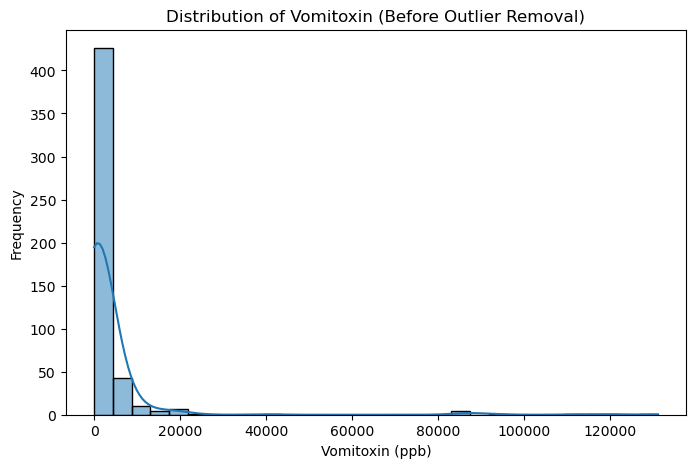

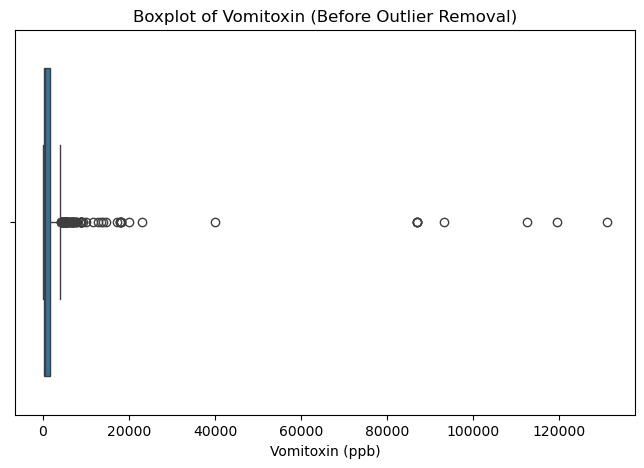

In [39]:
# Identify spectral columns
spectral_cols = df.columns[1:-1]  # Exclude 'hsi_id' and 'vomitoxin_ppb'

# Function to plot target distribution
def plot_target_distribution(df, title):
    plt.figure(figsize=(8, 5))
    sns.histplot(df['vomitoxin_ppb'], bins=30, kde=True)
    plt.title(title)
    plt.xlabel('Vomitoxin (ppb)')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot target boxplot
def plot_target_boxplot(df, title):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df['vomitoxin_ppb'])
    plt.title(title)
    plt.xlabel('Vomitoxin (ppb)')
    plt.show()

# Plot before outlier removal
plot_target_distribution(df, "Distribution of Vomitoxin (Before Outlier Removal)")
plot_target_boxplot(df, "Boxplot of Vomitoxin (Before Outlier Removal)")


In [40]:
# Step 1: Z-Score Method (Remove Extreme Outliers)**
z_scores = np.abs(stats.zscore(df['vomitoxin_ppb']))
df_z_filtered = df[z_scores < 3]

# Step 2: IQR Method (Fine-tune Outlier Removal)**
Q1 = df_z_filtered['vomitoxin_ppb'].quantile(0.25)
Q3 = df_z_filtered['vomitoxin_ppb'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df_z_filtered[(df_z_filtered['vomitoxin_ppb'] >= lower_bound) & 
                         (df_z_filtered['vomitoxin_ppb'] <= upper_bound)]


cleaned_file_path = "MLE-Assignment-Cleaned.csv"
df_clean.to_csv(cleaned_file_path, index=False)
print(f"Cleaned dataset saved as {cleaned_file_path}")


Cleaned dataset saved as MLE-Assignment-Cleaned.csv



Before Outlier Removal:
 count       500.000000
mean       3410.006000
std       13095.803483
min           0.000000
25%         137.500000
50%         500.000000
75%        1700.000000
max      131000.000000
Name: vomitoxin_ppb, dtype: float64

After Outlier Removal:
 count     411.000000
mean      593.194647
std       726.404756
min         0.000000
25%       100.000000
50%       300.000000
75%       800.000000
max      3500.000000
Name: vomitoxin_ppb, dtype: float64


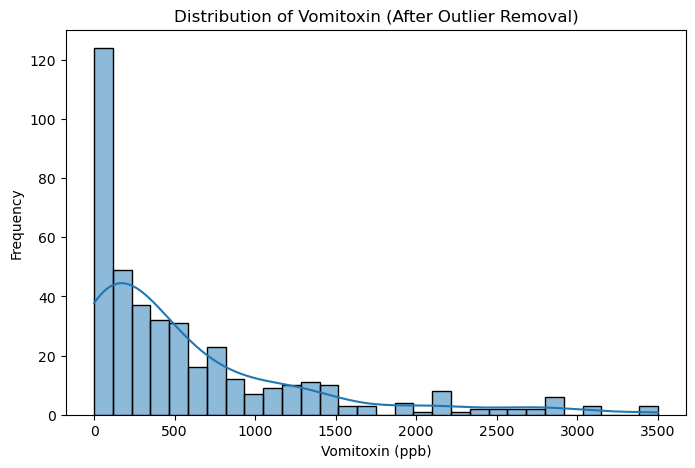

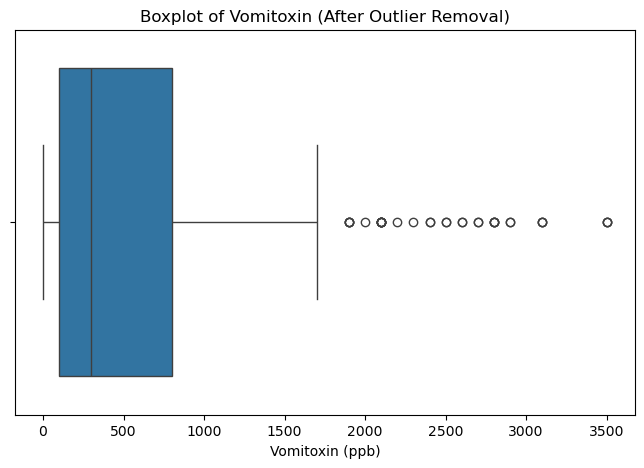

C:\Users\DELL\AppData\Local\Temp\ipykernel_1516\3723076026.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['log_vomitoxin'] = np.log1p(df_clean['vomitoxin_ppb'])


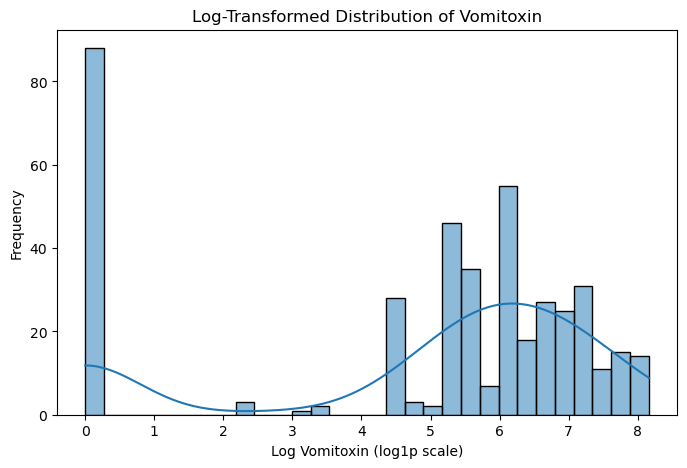

In [41]:
print("\nBefore Outlier Removal:\n", df['vomitoxin_ppb'].describe())
print("\nAfter Outlier Removal:\n", df_clean['vomitoxin_ppb'].describe())

# Plot after outlier removal
plot_target_distribution(df_clean, "Distribution of Vomitoxin (After Outlier Removal)")
plot_target_boxplot(df_clean, "Boxplot of Vomitoxin (After Outlier Removal)")

# Apply Log Transformation to reduce skewness
df_clean['log_vomitoxin'] = np.log1p(df_clean['vomitoxin_ppb'])

# Plot log-transformed data
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['log_vomitoxin'], bins=30, kde=True)
plt.title("Log-Transformed Distribution of Vomitoxin")
plt.xlabel("Log Vomitoxin (log1p scale)")
plt.ylabel("Frequency")
plt.show()


In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

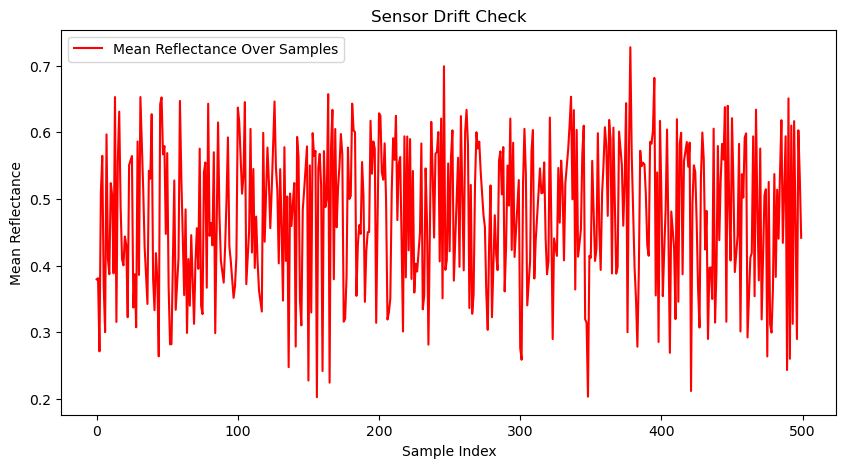

In [36]:
# Check for sensor drift (mean reflectance drift over time)
def check_sensor_drift(df):
    mean_reflectance = df[spectral_cols].mean(axis=1)
    plt.figure(figsize=(10, 5))
    plt.plot(mean_reflectance, label='Mean Reflectance Over Samples', color='red')
    plt.title('Sensor Drift Check')
    plt.xlabel('Sample Index')
    plt.ylabel('Mean Reflectance')
    plt.legend()
    plt.show()

check_sensor_drift(df_cleaned)


2025-03-16 11:51:29,193 - INFO - Loading dataset...
2025-03-16 11:51:29,302 - INFO - Scaling features...
2025-03-16 11:51:29,320 - INFO - Splitting data into training and testing sets...
2025-03-16 11:51:29,324 - INFO - Training Neural Network...
C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 1031464.3750 - mae: 628.3580 - val_loss: 983912.0625 - val_mae: 621.9844
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 829068.2500 - mae: 593.1307 - val_loss: 982336.8750 - val_mae: 621.1155
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 744503.9375 - mae: 544.3445 - val_loss: 981013.6250 - val_mae: 620.4911
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 885417.5000 - mae: 610.0264 - val_loss: 979806.5625 - val_mae: 619.9143
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 880208.0625 - mae: 591.7635 - val_loss: 978532.6875 - val_mae: 619.2991
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 848475.1250 - mae: 591.3151 - val_loss: 977814.3125 - val_mae: 619.0209
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 840151.8750 - mae: 593.1274 - val_loss: 975414.6250 - val_mae: 617.9048
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 908703.0000 - mae: 597.9904 - v

2025-03-16 11:52:23,902 - INFO - Neural Network MSE: 805437.4775600835
2025-03-16 11:52:23,904 - INFO - Training Gradient Boosting Model...
2025-03-16 11:52:32,688 - INFO - Gradient Boosting MSE: 532152.748697487
2025-03-16 11:52:32,690 - INFO - Starting hyperparameter tuning with Optuna...
[I 2025-03-16 11:52:32,692] A new study created in memory with name: no-name-81cbf19e-be6e-4e0a-89b2-2558f7899ae6
C:\Users\DELL\AppData\Local\Temp\ipykernel_1516\598748826.py:78: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.005, 0.2)
[I 2025-03-16 11:53:44,151] Trial 0 finished with value: 522800.058072003 and parameters: {'n_estimators': 302, 'learning_rate': 0.01355009919553959, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 522800.05

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49445
[LightGBM] [Info] Number of data points in the train set: 328, number of used features: 448
[LightGBM] [Info] Start training from score 601.887195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

2025-03-16 12:24:14,671 - INFO - LightGBM MSE: 457498.27834821725
2025-03-16 12:24:14,673 - INFO - Performing K-Fold Cross-Validation...


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2025-03-16 12:25:18,223 - INFO - Average K-Fold MSE: 512162.263340446
2025-03-16 12:25:18,226 - INFO - Performing K-Fold Cross-Validation...


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49445
[LightGBM] [Info] Number of data points in the train set: 328, number of used features: 448
[LightGBM] [Info] Start training from score 601.887195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

2025-03-16 12:25:20,543 - INFO - Average K-Fold MSE: 511680.22653349256
2025-03-16 12:25:20,545 - INFO - Generating SHAP feature importance plot...


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3


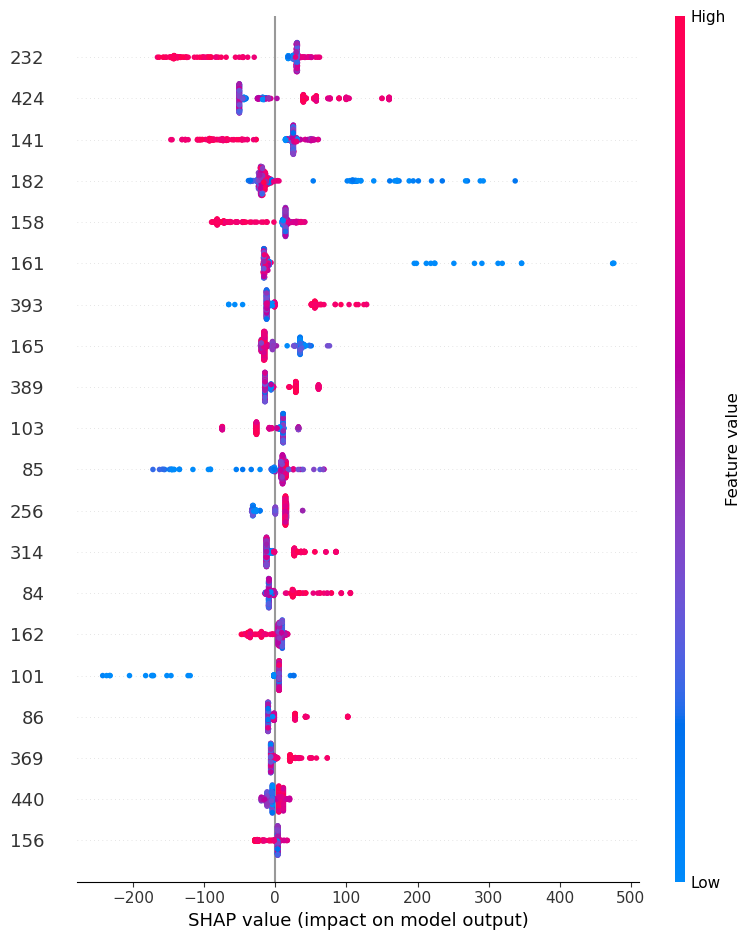

2025-03-16 12:25:23,215 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-16 12:25:23,225 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


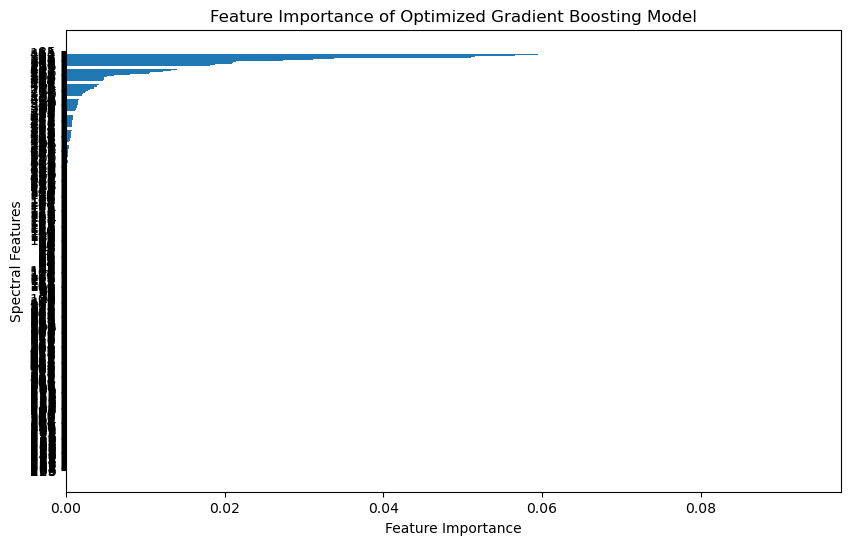

2025-03-16 12:25:29,942 - INFO - Saving models...
2025-03-16 12:25:29,970 - INFO - All models saved successfully!


In [32]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load preprocessed data (after outlier removal)
file_path = "MLE-Assignment-Cleaned.csv"  # Ensure this file is the cleaned version
logging.info("Loading dataset...")
df = pd.read_csv(file_path)

# Selecting features and target
spectral_cols = df.columns[1:-1]  # Exclude 'hsi_id' and 'vomitoxin_ppb'
X = df[spectral_cols]
y = df['vomitoxin_ppb']

# Scale features
logging.info("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
logging.info("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ======= Optimized Neural Network =======
def create_optimized_nn(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Regression output
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

logging.info("Training Neural Network...")
nn_model = create_optimized_nn(X_train.shape[1])
nn_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate Neural Network
nn_preds = nn_model.predict(X_test)
nn_mse = mean_squared_error(y_test, nn_preds)
logging.info(f"Neural Network MSE: {nn_mse}")

# ======= Baseline Gradient Boosting Model =======
def train_gbr(X_train, y_train, X_test, y_test):
    logging.info("Training Gradient Boosting Model...")
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    logging.info(f"Gradient Boosting MSE: {mse}")
    return model

gbr_model = train_gbr(X_train, y_train, X_test, y_test)

# ======= Hyperparameter Optimization using Optuna =======
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.005, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    model = GradientBoostingRegressor(
        n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

logging.info("Starting hyperparameter tuning with Optuna...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
logging.info(f"Best parameters: {study.best_params}")

# ======= Train Optimized Gradient Boosting Model =======
logging.info("Training optimized Gradient Boosting Model...")
best_gbr_model = GradientBoostingRegressor(**study.best_params, random_state=42)
best_gbr_model.fit(X_train, y_train)

# Evaluate the Optimized Model
best_preds = best_gbr_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_preds)
logging.info(f"Optimized Gradient Boosting MSE: {best_mse}")

# ======= LightGBM Model (Better & Faster) =======
logging.info("Training LightGBM Model...")
lgb_model = LGBMRegressor(**study.best_params, random_state=42)
lgb_model.fit(X_train, y_train)

# Evaluate LightGBM Model
lgb_preds = lgb_model.predict(X_test)
lgb_mse = mean_squared_error(y_test, lgb_preds)
logging.info(f"LightGBM MSE: {lgb_mse}")

# ======= K-Fold Cross-Validation =======
def k_fold_validation(model, X, y, k=5):
    logging.info("Performing K-Fold Cross-Validation...")
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    logging.info(f"Average K-Fold MSE: {avg_mse}")

k_fold_validation(best_gbr_model, X_scaled, y)
k_fold_validation(lgb_model, X_scaled, y)

# ======= Feature Importance using SHAP =======
logging.info("Generating SHAP feature importance plot...")
explainer = shap.Explainer(best_gbr_model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=spectral_cols)

# Feature Importance Plot
feature_importance = best_gbr_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(np.array(spectral_cols)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Spectral Features")
plt.title("Feature Importance of Optimized Gradient Boosting Model")
plt.show()

# ======= Save the best model =======
logging.info("Saving models...")
joblib.dump(best_gbr_model, "best_gbr_model.pkl")
joblib.dump(lgb_model, "best_lgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
logging.info("All models saved successfully!")

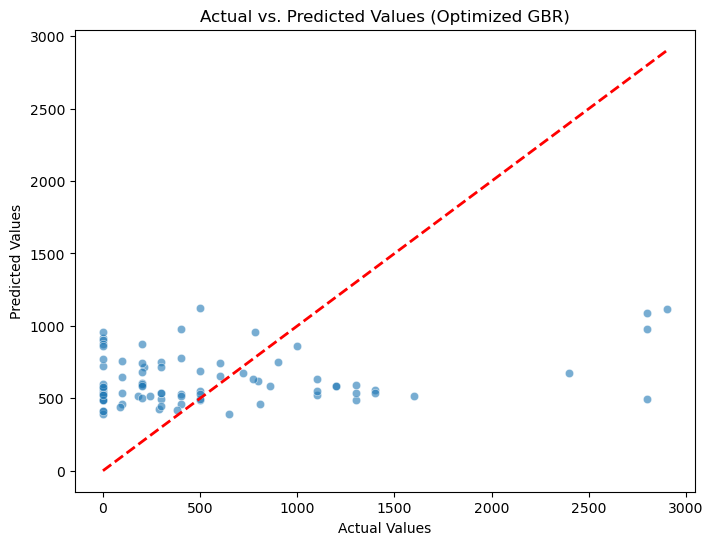

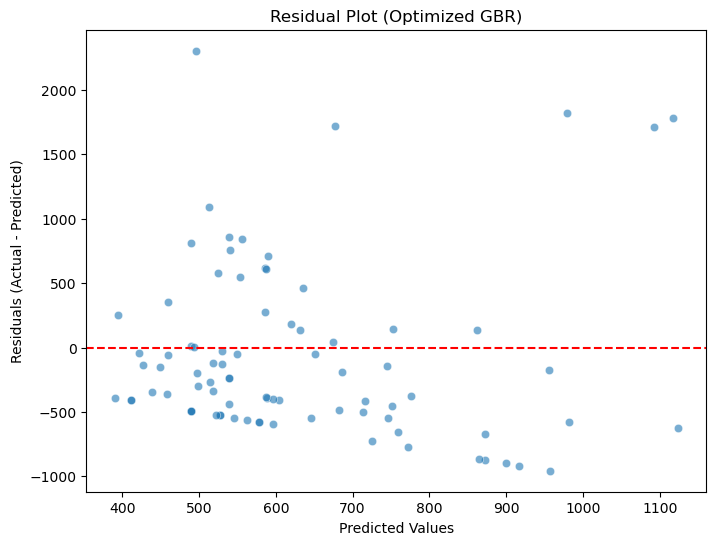

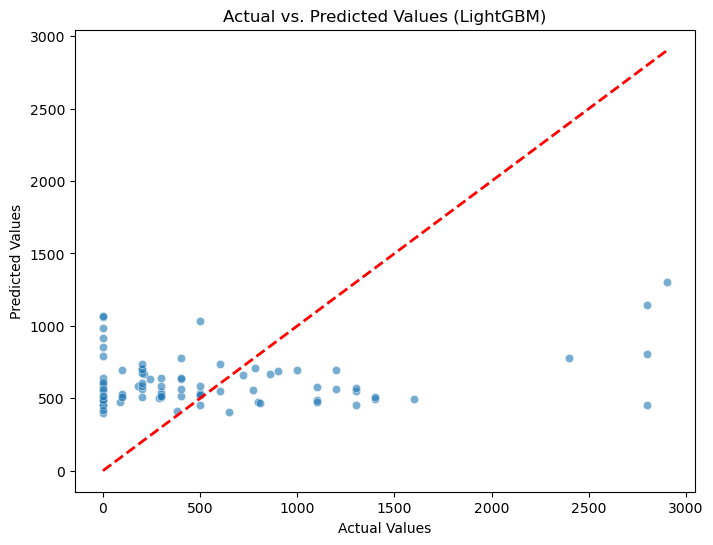

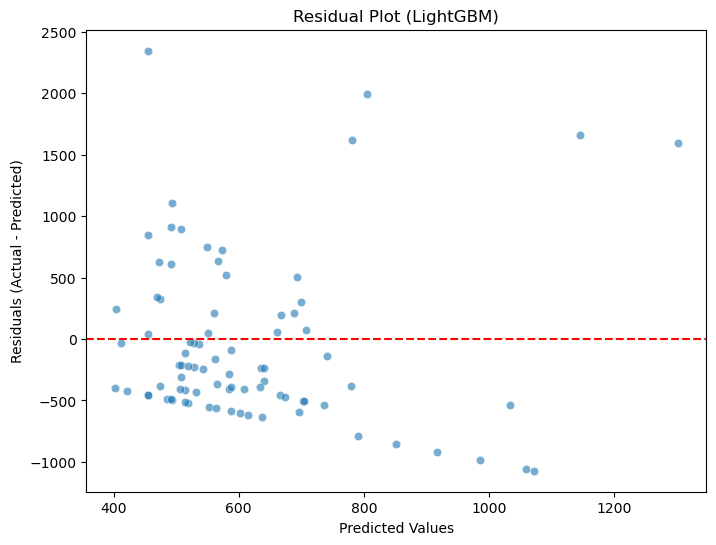

In [34]:
import seaborn as sns

# Function to plot actual vs predicted scatter plot
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)  # 45-degree line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs. Predicted Values ({model_name})")
    plt.show()

# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"Residual Plot ({model_name})")
    plt.show()

# Scatter and residual plots for best models
plot_actual_vs_predicted(y_test, best_preds, "Optimized GBR")
plot_residuals(y_test, best_preds, "Optimized GBR")

plot_actual_vs_predicted(y_test, lgb_preds, "LightGBM")
plot_residuals(y_test, lgb_preds, "LightGBM")


In [ ]:
import pytest
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Sample data for testing
data = {
    "hsi_id": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "feature_1": [10, 12, 14, 11, 13, 15, 14, 12, 300, 11],  # 300 is an outlier
    "vomitoxin_ppb": [1, 2, 3, 2, 1, 2, 1, 3, 50, 2]  # 50 is an outlier
}
df = pd.DataFrame(data)

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Function to apply log transformation
def apply_log_transformation(df, column):
    df[f"log_{column}"] = np.log1p(df[column])
    return df

# Unit tests
def test_remove_outliers():
    cleaned_df = remove_outliers(df, "vomitoxin_ppb")
    assert 50 not in cleaned_df["vomitoxin_ppb"].values, "Outlier not removed"
    
    cleaned_df = remove_outliers(df, "feature_1")
    assert 300 not in cleaned_df["feature_1"].values, "Feature outlier not removed"

def test_log_transformation():
    transformed_df = apply_log_transformation(df.copy(), "vomitoxin_ppb")
    assert "log_vomitoxin_ppb" in transformed_df.columns, "Log transformation column missing"
    assert all(transformed_df["log_vomitoxin_ppb"] > 0), "Log transformation incorrect"

def test_no_negative_values_after_log():
    transformed_df = apply_log_transformation(df.copy(), "vomitoxin_ppb")
    assert all(transformed_df["log_vomitoxin_ppb"] >= 0), "Negative values in log transformation"

if __name__ == "__main__":
    pytest.main()